# 0. Install dependencies and bring up data

In [2]:
!pip install tensorflow pandas matplotlib scikit-learn

  Using cached tensorflow-2.13.0-cp311-cp311-macosx_10_15_x86_64.whl (216.3 MB)
  Using cached pandas-2.0.3-cp311-cp311-macosx_10_9_x86_64.whl (11.6 MB)
  Using cached matplotlib-3.7.2-cp311-cp311-macosx_10_12_x86_64.whl (7.4 MB)
  Using cached scikit_learn-1.3.0-cp311-cp311-macosx_10_9_x86_64.whl (10.1 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.9.0-cp311-cp311-macosx_10_9_x86_64.whl (3.2 MB)
  Using cached libclang-16.0.6-py2.py3-none-macosx_10_9_x86_64.whl (24.5 MB)
  Using cached numpy-1.24.3-cp311-cp311-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 8.1 MB/s eta 0:00:000:00:01
  Using cached termcolor-2.3.0-py3-

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

2023-08-21 09:35:27.493599: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
df = pd.read_csv(os.path.join('raw_data', 'train.csv'))

In [9]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
df.iloc[43]['comment_text']

'FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!'

In [11]:
df[df.columns[2:]].iloc[43]

toxic            1
severe_toxic     0
obscene          1
threat           0
insult           1
identity_hate    0
Name: 43, dtype: int64

# 1. Preprocess

In [12]:
from tensorflow.keras.layers import TextVectorization

In [13]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [14]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [15]:
MAX_FEATURES = 200000 # number of words in the vocab

In [16]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [17]:
vectorizer.adapt(X.values) # teach the vectorizer our vocab

In [18]:
vectorizer.get_vocabulary()[:10] # list of the vocab that just learnt (first 10 words)

['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'you', 'i', 'is']

In [19]:
vectorizer('I love you bro!')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([  8, 457,   7, ...,   0,   0,   0])>

In [20]:
vectorized_text = vectorizer(X.values)

In [21]:
vectorized_text.shape

TensorShape([159571, 1800])

In [22]:
# initiate tensorflow Dataset Pipeline
# tf dataset rule (MCSHBAP) -> Map - Cache - SHuffle - BAtch - Prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000) # biffer size
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps prevent bottlenecks

In [23]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [24]:
batch_X.shape

(16, 1800)

In [25]:
batch_y.shape

(16, 6)

#### Partition the data

In [26]:
train = dataset.take(int(len(dataset) * .7))
val  = dataset.skip(int(len(dataset) * .7)).take(int(len(dataset) * .2))
test = dataset.skip(int(len(dataset) * .9)).take(int(len(dataset) * .1))

In [53]:
train.as_numpy_iterator().next()

(array([[     2,    854,    308, ...,      0,      0,      0],
        [   490,   1188,   3229, ...,      0,      0,      0],
        [100078,   2015,   2965, ...,      0,      0,      0],
        ...,
        [ 71222,  22620,   3114, ...,      0,      0,      0],
        [ 36039,   7989,     70, ...,      0,      0,      0],
        [     8,    590,     12, ...,      0,      0,      0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

# 2. Create the Sequential Model

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [59]:
model = Sequential()
# Create Embedding Layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#Final layer
model.add(Dense(6, activation='sigmoid'))

In [60]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                      

In [62]:
hist = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 6557s 939ms/step - loss: 0.0624 - val_loss: 0.0459


In [69]:
hist.history

{'loss': [0.062407393008470535], 'val_loss': [0.045858077704906464]}

In [27]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

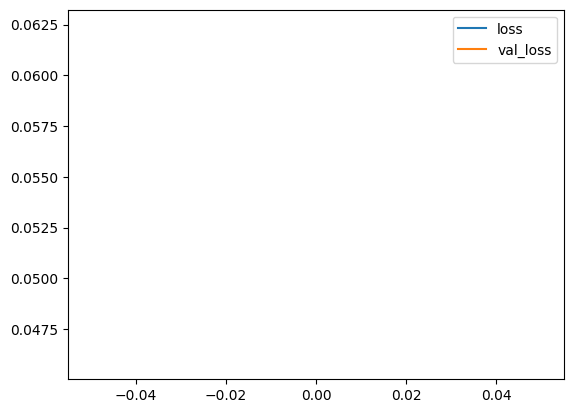

In [70]:
# it would be nice to train with 5 to 10 epoch to have a better plot
plt.figure(figsize=(8, 5))
pd.DataFrame(hist.history).plot()
plt.show()

#### Save the model

In [65]:
model.save('models/toxicityDetection.keras')

# 3. Make predictions

In [75]:
input_text = vectorizer('Go to hell, asshole')

In [74]:
model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 1s 754ms/step


array([[0.9927648 , 0.20831062, 0.93264353, 0.01279617, 0.7949572 ,
        0.1069115 ]], dtype=float32)

In [85]:
res = (model.predict(np.expand_dims(input_text, 0)) > 0.5).astype(int)

1/1 [==============================] - 0s 133ms/step


In [86]:
res

array([[1, 0, 1, 0, 1, 0]])

# 4. Evaluate model

In [28]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [88]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # unpack the batch
    X_true, y_true = batch
    # make a prediction
    yhat = model.predict(X_true)
    
    # flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [90]:
print(f'Precision: {pre.result().numpy()}\nRecall: {re.result().numpy()}\nAccuracy: {acc.result().numpy()}')

Precision: 0.8598096370697021
Recall: 0.6462173461914062
Accuracy: 0.45937812328338623


# 5. Test and Use in Gradio

In [107]:
!pip install gradio jinja2 ipywidgets


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [132]:
!pip install typing-extensions==4.5.0

> Needed to downgrade version of typing_extension to 4.5.0 to import gradio correctly

In [32]:
import gradio as gr

In [29]:
from tensorflow.keras.models import load_model

In [30]:
model = load_model('models/toxicityDetection.keras')

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                      

In [33]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += f'{col}: {results[0][idx]>0.5}\n'
        
    return text

In [39]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text'
                        )

In [41]:
interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 105ms/step
